# Project Name: Musical Genre Classification 

 ### Team Member:
    1. Mohammad Wasif Islam
    2. Sarker Miraz Mahfuz
    3. Rakibuzzaman Mahmud


## Motivation:

- An automatic genre classification algorithm could greatly increase efficiency for music databases. 
- It could also help music recommender systems and playlist generators that companies like Spotify and Pandora use.
- It’s also a really fun problem to play around with if you love music.





## There are two major challenges with this project:

1. Musical genres are loosely defined. So much so that people often argue over the genre of a song.
2. Extracting important features from audio data is itself a challange that could be used to train a model.



## Objective:


Our Goal is to build a model that could automatically classify a song by its genre, which is a multiclass classification task. 

## Dataset

This dataset was used for the well known paper in genre classification " Musical genre classification of audio signals " by G. Tzanetakis and P. Cook in IEEE Transactions on Audio and Speech Processing 2002.


Dataset Link: http://marsyas.info/downloads/datasets.html

### Dataset Description:

The datset consists of 10 genres and each genres have 100 samples.
Genres:

Duration of sound of each track is 30 seconds. 

1. jazz
2. reggae
3. rock
4. blues
5. hiphop
6. country
7. metal
8. classical
9. disco
10. pop

#### We used random 80% data of each genre as training set and 20% of each genre as validation set. 





## Tests with a Single Audio File
1. Understand how audio is processed
2. Determine what features to extract from the audio signal
3. Understand what each feature represents and how it is calculated
4. Write a function that reads and extracts important numeric features from a given directory
5. Write a function that reads audio signals and extracts the mel spectrograms 


In [8]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

### Extracting an Audio Signal

- Librosa is a python library that allows us to extract waveforms from audio files along with several other features. 
- This is the primary package that will be used for this project.

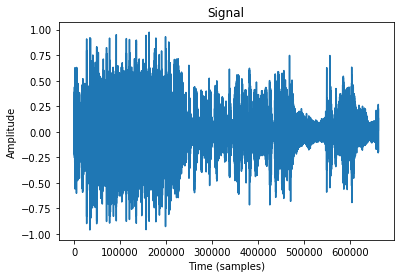

In [9]:
# Extracting the wave, "y", and sampling rate, "sr", of the audio file
y, sr = librosa.load('../data/wavfiles/rock.00000.wav')

plt.plot(y);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

### Mel Spectrograms
- Spectrograms are a way to visually represent a signal's loudness, or amplitude, as it varies over time at different frequencies. 
- The horizontal axis is time, the vertical axis is frequency, and the color is amplitude. 

- It is calculated using the fast Fourier transform on short time windows of the signal and transforming the vertical axis (frequency) to log scale and the colored axis (amplitude) to decibals. 

- A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.

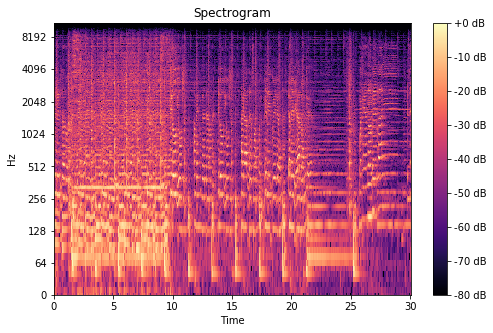

In [10]:
# Computing the spectrogram
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max) # converting to decibals

# Plotting the spectrogram
plt.figure(figsize=(8,5));
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

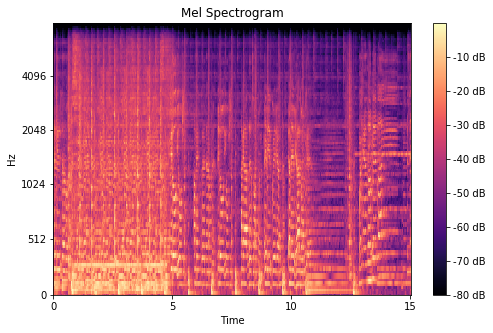

In [11]:
# Computing the mel spectrogram
spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
spect = librosa.power_to_db(spect, ref=np.max) # Converting to decibals

# Plotting the mel spectrogram
plt.figure(figsize=(8,5))
librosa.display.specshow(spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

### Mel Frequency Cepstral Coefficients (MFCC)

- MFCCs are commonly used features in the field of music information retrieval (MIR). 
- Cepstrum is the information of rate of change in spectral bands

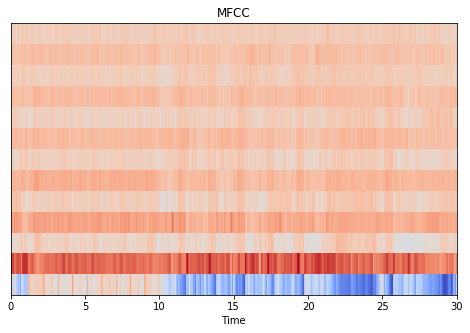

In [12]:
# Extracting mfccs from the audio signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)

plt.figure(figsize=(8,5));
librosa.display.specshow(mfcc, x_axis='time');
plt.title('MFCC');

## Data Preprocessing

- Values of the mel spectrograms should be scaled so that they are between 0 and 1 for computational efficiency.
- The data is currently 1000 rows of mel spectrograms that are 128 x 660. We need to reshape this to be 1000 rows of 128 x 660 x 1 to represent that there is a single color channel. 
- Target values have to be one-hot-encoded in order to be fed into a neural network.

In [13]:
def extract_mel_spectrogram(directory):
    
    labels = []
    mel_specs = []
    
    for file in os.scandir(directory):
        
        y, sr = librosa.core.load(file)
        
        # Extracting the label and adding it to the list. Label according to the file name
        label = str(file).split('.')[0][11:]
        labels.append(label)
        
        # Computing the mel spectrograms
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        
        # Adjusting the size to be 128 x 660
        if spect.shape[1] != 660:
            spect.resize(128,660, refcheck=False)
            
        mel_specs.append(spect)
        

    X = np.array(mel_specs)
    
    # Converting labels to numeric values
    labels = pd.Series(labels)
    label_dict = {
        'jazz': 0,
        'reggae': 1,
        'rock': 2,
        'blues': 3,
        'hiphop': 4,
        'country': 5,
        'metal': 6,
        'classical': 7,
        'disco': 8,
        'pop': 9
    }
    y = labels.map(label_dict).values
    
    return X, y

In [14]:

X, y = extract_mel_spectrogram('../data/wavfiles')

In [15]:
# Train test split. 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

In [16]:
# Checking the minimum value (the scale ranges from zero to some negative value) to see how we should scale the data
train_min = X_train.min()
test_min = X_train.min()
print(train_min)
print(test_min)

-80.0
-80.0


In [17]:
# Scaling our data to be between 0 and 1 using the minimum value from above
X_train /= train_min
X_test /= train_min

In [18]:
# Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)

In [19]:
# One hot encoding our labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Constructing a CNN

This is the summary of our architecture for the CNN:

- Input layer: 128 x 660 neurons (128 mel scales and 660 time windows)
- Convolutional layer: 16 different 3 x 3 filters
- Max pooling layer: 2 x 4
- Convolutional layer: 32 different 3 x 3 filters
- Max pooling layer: 2 x 4
- Dense layer: 64 neurons
- Output layer: 10 neurons for the 10 different genres (softmax activation)

In [20]:
np.random.seed(23456)
cnn_model = Sequential(name='cnn')

cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,660,1)))

cnn_model.add(MaxPooling2D(pool_size=(2,4)))
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,4)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(10, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=15)


Epoch 1/15
50/50 [==============================] - 23s 462ms/step - loss: 2.3838 - accuracy: 0.1125 - val_loss: 2.2950 - val_accuracy: 0.1000
Epoch 2/15
50/50 [==============================] - 22s 437ms/step - loss: 2.2768 - accuracy: 0.1187 - val_loss: 2.2875 - val_accuracy: 0.1800
Epoch 3/15
50/50 [==============================] - 22s 437ms/step - loss: 2.1555 - accuracy: 0.2163 - val_loss: 2.0857 - val_accuracy: 0.3200
Epoch 4/15
50/50 [==============================] - 22s 444ms/step - loss: 1.9007 - accuracy: 0.3388 - val_loss: 1.9150 - val_accuracy: 0.2750
Epoch 5/15
50/50 [==============================] - 29s 586ms/step - loss: 1.6686 - accuracy: 0.4050 - val_loss: 1.5769 - val_accuracy: 0.4900
Epoch 6/15
50/50 [==============================] - 23s 469ms/step - loss: 1.3893 - accuracy: 0.5163 - val_loss: 1.4945 - val_accuracy: 0.4750
Epoch 7/15
50/50 [==============================] - 26s 512ms/step - loss: 1.1948 - accuracy: 0.5888 - val_loss: 1.3142 - val_accuracy: 0.5400

In [ ]:
#from tensorflow import keras
#cnn_model = keras.models.load_model('cnn_classifier.h5')

In [21]:
# Checking the model summary
cnn_model.summary()
cnn_model.save('cnn_classifier.h5')

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 658, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 164, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 162, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 40, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2457664   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0       

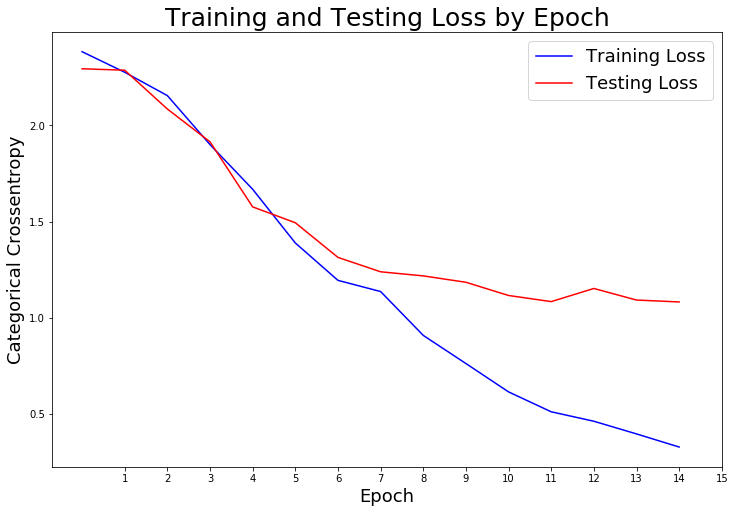

In [22]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,16), range(1,16))

plt.legend(fontsize = 18);

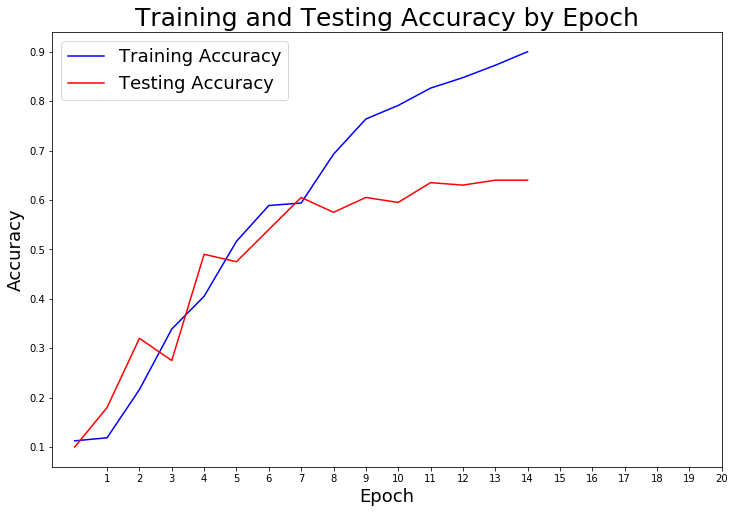

In [23]:
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(1,21), range(1,21))

plt.legend(fontsize = 18);

# Making predictions from our cnn model


In [24]:
predictions = cnn_model.predict(X_test, verbose=1)

7/7 [==============================] - 3s 429ms/step


In [25]:
labels_dict = {
    0: 'jazz',
    1: 'reggae',
    2: 'rock',
    3: 'blues',
    4: 'hiphop',
    5: 'country',
    6: 'metal',
    7: 'classical',
    8: 'disco',
    9: 'pop'
}

In [26]:
# Checking the number of targets per class
for i in range(10): 
    print(f'{i} {labels_dict[i]}: {sum([1 for target in y_test if target[i] == 1])}')

0 jazz: 20
1 reggae: 20
2 rock: 20
3 blues: 20
4 hiphop: 20
5 country: 20
6 metal: 20
7 classical: 20
8 disco: 20
9 pop: 20


In [27]:
# Checking the number of predicted values in each class
for i in range(10): 
    print(f'{i} {labels_dict[i]}: {sum([1 for prediction in predictions if np.argmax(prediction) == i])}')

0 jazz: 15
1 reggae: 14
2 rock: 11
3 blues: 20
4 hiphop: 26
5 country: 21
6 metal: 17
7 classical: 21
8 disco: 34
9 pop: 21


## Confusion matrix

In [28]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
confusion_df = pd.DataFrame(conf_matrix)
confusion_df = confusion_df.rename(columns=labels_dict)
confusion_df.index = confusion_df.columns
confusion_df

,jazz,reggae,rock,blues,hiphop,country,metal,classical,disco,pop
jazz,9,0,1,1,1,2,0,4,1,1
reggae,1,11,0,3,2,1,0,0,2,0
rock,1,3,6,4,0,1,0,0,4,1
blues,2,0,0,11,2,3,0,0,2,0
hiphop,1,0,0,0,16,0,0,0,2,1
country,1,0,1,1,1,11,0,0,4,1
metal,0,0,2,0,0,0,17,0,1,0
classical,0,0,1,0,0,1,0,16,2,0
disco,0,0,0,0,4,2,0,0,14,0
pop,0,0,0,0,0,0,0,1,2,17


(10.0, 0)

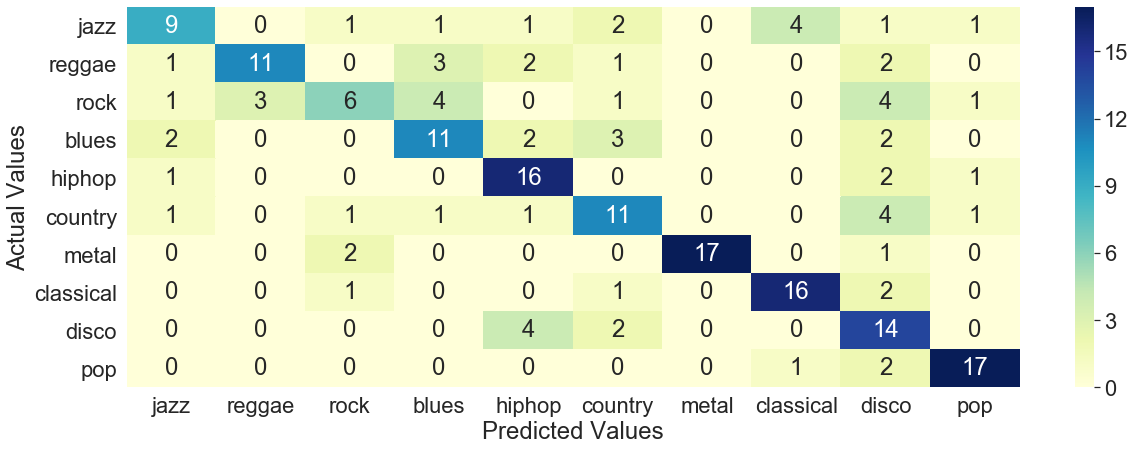

In [29]:
import seaborn as sns
# Creating a heatmap for the confusion matrix for display
plt.figure(figsize= (20,7))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df, annot=True,cmap='YlGnBu');
ax.set(xlabel='Predicted Values', ylabel='Actual Values');

ax.set_ylim(10.0, 0)

## Testing sample data 

In [56]:
X_metal, y_metal = extract_mel_spectrogram('../sample')
X_metal /= X_train.min()
X_metal = X_metal.reshape(X_metal.shape[0], 128, 660, 1)
print(y_metal)

[7 6 3 3 9]


In [57]:
my_predictions = cnn_model.predict(X_metal, verbose=1)
print(my_predictions)

1/1 [==============================] - 0s 1ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [58]:
# Checking the number of predicted values in each class
for i in range(10): 
    print(f'{i} {labels_dict[i]}: {sum([1 for prediction1 in my_predictions if np.argmax(prediction1) == i])}')

    

0 jazz: 1
1 reggae: 1
2 rock: 0
3 blues: 1
4 hiphop: 2
5 country: 0
6 metal: 0
7 classical: 0
8 disco: 0
9 pop: 0


The best CNN model (based on test score accuracy) achieved a score of 64%. The training score was 90%, so the model was overfit. This means that it was tuning really well to the training data and not generalizing as well to new data.

Most of the models became increasingly overfit after about 15-20 epochs, so increasing the number of epochs would not improve the model.

Based on the confusion matrix, the computer was confusing some genres for others similarly to how humans would.

This is a good sign that our model is running into the same difficulties that a human would. It's clearly learning some distinguishing factors of the musical genres, but it is having trouble with genres that share characteristics with other genres.